# Starting Assignment to Analyze Toronto Neighborhoods

#### To begin, we would scrape data from a Wikipedia page

In [2]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

In [9]:
# installing beautifulsoup
!pip install beautifulsoup4

In [4]:
!pip install lxml

     |████████████████████████████████| 5.8MB 14.7MB/s eta 0:00:01


In [10]:
# Import libraries
import requests
import lxml.html as lh
from bs4 import BeautifulSoup

#### Reading the Wikipedia page

In [11]:
src = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(src, 'lxml')
#print(soup.prettify())

In [12]:
## Reading the table
tbl = soup.find("table")

#### Storing the table into a staging Data Frame which would be processed later

In [13]:
# Finding all rows
j=1
# Creating a blank list to store table data
lstCan = []
for tr in tbl.tbody.find_all("tr"):
    lstCan.append(tr.text.replace('\n',',').rstrip(',').lstrip(',').split(',')) #Replace NL char with commas and split chars to create tuples/lists. 
    j=j+1

# Creating a data frame with items from list. First row considered as header. However, as we are chanding the column Names, providing column headers manually.
dfToronto = pd.DataFrame(lstCan[1:],columns=['PostalCode','Borough','Neighbourhood'])

# Printing 5 rows
dfToronto.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Data Cleanup - Removing rows without a Borough, Combining Neighbourhoods with same postal code etc.

In [14]:
# Find rows without a Borough
dfTrntNew = dfToronto[dfToronto['Borough']!='Not assigned']
dfTrntNew = dfTrntNew.copy()

In [15]:
# Assigning Borough Name where Neighbourhood is Not assigned
dfTrntNew['Neighbourhood'] = np.where(dfTrntNew['Neighbourhood']=='Not assigned', dfTrntNew['Borough'], dfTrntNew['Neighbourhood'])

In [16]:
# Combining the Neighbourhoods with same PostalCode
dfTorNbh = dfTrntNew.groupby(['PostalCode','Borough'], sort=True)['Neighbourhood'].apply(','.join).reset_index()
dfTorNbh.head(10)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [17]:
# Printing number of rows
dfTorNbh.shape

(103, 3)

### Starting to get Coordinates for Neighbourhoods

In [165]:
!pip install geocoder
import geocoder
print("Completed installing and importing geocoder...")

Completed installing and importing geocoder...


##### Create a function to get Lat/Long for a neighbourhood

In [13]:
# creating function getGCodes

def getGCodes(nbh):
    # initialize your variable to None
    lat_lng = None

    # loop until you get the coordinates
    while(lat_lng is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(nbh))
      lat_lng = g.latlng

    latitude = lat_lng[0]
    longitude = lat_lng[1]

In [ ]:
nbh = 'M1B'
getGCodes(nbh)

Status code Unknown from https://maps.googleapis.com/maps/api/geocode/json: ERROR - ('Connection aborted.', OSError("(104, 'ECONNRESET')",))


### Due to the failure received above, reverting to the CSV file provided

In [14]:
!wget -q -O 'toronto_data.csv' https://cocl.us/Geospatial_data

In [18]:
dfTorLatLon = pd.read_csv('toronto_data.csv')
dfTorLatLon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
dfTorNbh["Latitude"] = dfTorLatLon["Latitude"]
dfTorNbh["Longitude"] = dfTorLatLon["Longitude"]

In [20]:
dfTorNbh.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Starting to Cluster and Analyze data

In [21]:
# Importing libraries for Clustering and Plotting
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

In [22]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [23]:
print("Toronto, Canada dataset has {} Boroughs and {} Neighborhoods".format(len(dfTorNbh["Borough"].unique()), len(dfTorNbh["PostalCode"].unique())))

Toronto, Canada dataset has 10 Boroughs and 103 Neighborhoods


#### Mapping Toronto City on the map

In [24]:
address = 'Toronto, Ontario, CA'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, CA are 43.653963, -79.387207.


#### Starting Analysis of Data for Neighbourhoods with "Toronto"in their name

In [25]:
# Data frame for neighbourhoods with Toronto in their names
dfdwnTor = dfTorNbh[dfTorNbh['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [26]:
# Plotting a map of Toronto as a base
address = 'Toronto, Ontario, CA'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [27]:
# create map of Downtown Toronto using latitude and longitude values
map_dwnTor = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfdwnTor['Latitude'], dfdwnTor['Longitude'], dfdwnTor['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dwnTor)  
    
map_dwnTor

#### Analyzing data for one neighbourhood

In [28]:
dfdwnTor.loc[0,'Neighbourhood']

'The Beaches'

#### Getting coordinates for The Beaches

In [29]:
neighborhood_latitude = dfdwnTor.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfdwnTor.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dfdwnTor.loc[0, 'Neighbourhood'] # neighborhood name
pstlCode_name = dfdwnTor.loc[0, 'PostalCode'] # Postal Code

print('Latitude and longitude values of {} ({}) are {}, {}.'.format(neighborhood_name,
                                                                  pstlCode_name,
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches (M4E) are 43.67635739999999, -79.2930312.


#### Analyzing The Beaches neighbourhood for Hospitals and Gyms/Fitness Center

In [30]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200301'
LIMIT = 100
radius = 500
#search_query = 'Gym;Hospital'
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url

In [31]:
results = requests.get(url).json()

#### Creating function to read the Category Name. This is required as the Cateory in the response is separate array

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Creating a DF for all POI in the Neighbourhood

In [33]:
venues = results['response']['groups'][0]['items']
  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
3,Karine's,Breakfast Spot,43.653699,-79.390743
4,Rolltation,Japanese Restaurant,43.654918,-79.387424
5,Poke Guys,Poke Place,43.654895,-79.385052
6,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
7,Fugo Desserts,Ice Cream Shop,43.654923,-79.387382
8,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684
9,The Library Specialty Coffee,Coffee Shop,43.654413,-79.390902


In [34]:
print('{} venues were returned by Foursquare API for {} neighbourhood.'.format(nearby_venues.shape[0], dfdwnTor.loc[0,'Neighbourhood']))

73 venues were returned by Foursquare API for The Beaches neighbourhood.


### Analyzing all neighbourhoods in Toronto (with Toronto in their names)

#### Let's create a function to repeat the process to all the neighborhoods

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the Function for all Neighbourhoods (Postal Codes)

In [36]:
toronto_venues = getNearbyVenues(names= dfdwnTor['Neighbourhood'],
                                   latitudes=dfdwnTor['Latitude'],
                                   longitudes=dfdwnTor['Longitude']
                                  )

In [37]:
print('There are {} uniques categories as listed below:'.format(len(toronto_venues['Venue Category'].unique())))
print(toronto_venues['Venue Category'].unique())

There are 238 uniques categories as listed below:
['Trail' 'Health Food Store' 'Pub' 'Neighborhood' 'Coffee Shop'
 'Greek Restaurant' 'Cosmetics Shop' 'Italian Restaurant' 'Ice Cream Shop'
 'Yoga Studio' 'Brewery' 'Fruit & Vegetable Store' 'Pizza Place'
 'Bookstore' 'Restaurant' 'Bubble Tea Shop' 'Juice Bar' 'Dessert Shop'
 'Spa' 'Diner' 'Grocery Store' 'Furniture / Home Store' 'Café' 'Bakery'
 'Caribbean Restaurant' 'Frozen Yogurt Shop' 'American Restaurant'
 'Liquor Store' 'Gym' 'Fish & Chips Shop' 'Fast Food Restaurant' 'Park'
 'Sushi Restaurant' 'Pet Store' 'Steakhouse' 'Burrito Place'
 'Movie Theater' 'Sandwich Place' 'Board Shop' 'Food & Drink Shop'
 'Fish Market' 'Gay Bar' 'Cheese Shop' 'Middle Eastern Restaurant'
 'Comfort Food Restaurant' 'Seafood Restaurant' 'Thai Restaurant'
 'Stationery Store' 'Coworking Space' 'Wine Bar' 'Bar'
 'Latin American Restaurant' 'Gym / Fitness Center' 'Gastropub' 'Bank'
 'Clothing Store' 'Convenience Store' 'Thrift / Vintage Store'
 'Swim School'

#### Now that we have our data set for all categories (limited 100) for Toronto Area, we would find the most frequented places in Neighbourhood

In [38]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print("Total data records avaialble:",toronto_onehot.shape)

Total data records avaialble: (1731, 238)


#### As we can see the data is not grouped and does not provide precise information yet. We would need to group the data by neighborhood and find the mean for all categories

In [39]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print("Total data records avaialble after grouping:",toronto_grouped.shape)

Total data records avaialble after grouping: (39, 238)


##### Function to create and sort venues in descending order

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Using the above function, we would find the sorted frequented places in every neighborhood

In [41]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

#### Finding the top 5 places frequented in Toronto Neighborhoods

In [42]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Thai Restaurant,Café,Bar,Restaurant
1,Berczy Park,Coffee Shop,Farmers Market,French Restaurant,Bakery,Seafood Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Café,Breakfast Spot,Coffee Shop,Bakery,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Skate Park,Smoke Shop
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Sculpture Garden
5,"Cabbagetown,St. James Town",Coffee Shop,Bakery,Pizza Place,Italian Restaurant,Pharmacy
6,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Ice Cream Shop,Juice Bar
7,"Chinatown,Grange Park,Kensington Market",Bar,Vietnamese Restaurant,Café,Chinese Restaurant,Bakery
8,Christie,Grocery Store,Café,Park,Baby Store,Restaurant
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant


#### Some interesting facts about the above data can be found with below code. In the parameter, we can provide a Category Name such as Gym or Park or Trail and check the neighborhoods that have these categories in top 5. Such neighborhoods are likely to be habited by health aware families.

In [44]:
srchQ = ["Gym","Park"]

for srchStr in srchQ:
    mask = np.column_stack([neighborhoods_venues_sorted[col].str.contains(srchStr, na=False) for col in neighborhoods_venues_sorted])
    print("# of Neighborhoods that have {} as top 5 place of interest = {} ".format(srchStr,neighborhoods_venues_sorted.loc[mask.any(axis=1)]["Neighborhood"].count()))
    print(neighborhoods_venues_sorted.loc[mask.any(axis=1)]["Neighborhood"])
    print("\n")

# of Neighborhoods that have Gym as top 5 place of interest = 7 
2     Brockton,Exhibition Place,Parkdale Village
10                 Commerce Court,Victoria Hotel
11                                    Davisville
12                              Davisville North
16         First Canadian Place,Underground city
27                                  Queen's Park
37                 The Beaches West,India Bazaar
Name: Neighborhood, dtype: object


# of Neighborhoods that have Park as top 5 place of interest = 15 
1                                           Berczy Park
2            Brockton,Exhibition Place,Parkdale Village
3     Business Reply Mail Processing Centre 969 Eastern
7               Chinatown,Grange Park,Kensington Market
8                                              Christie
13    Deer Park,Forest Hill SE,Rathnelly,South Hill,...
17                   Forest Hill North,Forest Hill West
19                                         Harbourfront
21                         High Park,The 

## Clustering Neighborhoods

### Verifying the K-Value for the clustering

In [61]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 0, 4, 4, 4, 4, 2, 4], dtype=int32)

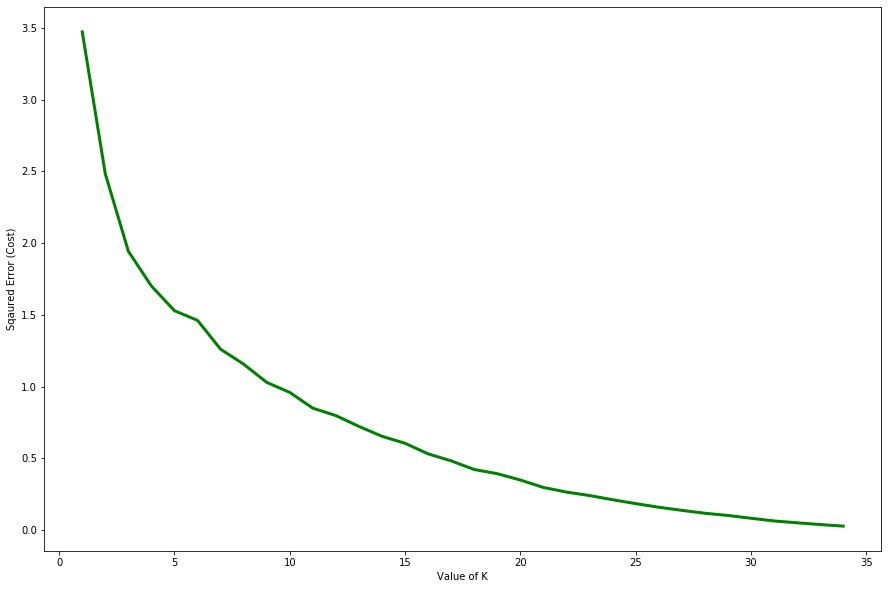

In [62]:
cost =[] 
for i in range(1, 35): 
    kverify = KMeans(n_clusters=i, random_state=0).fit(toronto_grouped_clustering)

    # calculates squared error 
    # for the clustered points 
    cost.append(kverify.inertia_)

# plot the cost against K values 
plt.figure(figsize=(15,10))
plt.plot(range(1, 35), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

# the point of the elbow is the 
# most optimal value for choosing k 


#### Based on the above chart, the ideal number of clusters are hard to find because there is no clear Elbow Point. However, the decrease in cost is flattening after K=10. Hence, we would be trying to create 10 clusters.

In [63]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [64]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dfdwnTor

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,9,Trail,Coffee Shop,Health Food Store,Pub,Doner Restaurant
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,4,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Furniture / Home Store
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,2,Park,Sandwich Place,Pizza Place,Gym,Board Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Bakery,Brewery
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,6,Park,Swim School,Bus Line,Women's Store,Dim Sum Restaurant


### Visualizing Data Now

In [65]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining All Clusters

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
38,East Toronto,0,Light Rail Station,Yoga Studio,Auto Workshop,Skate Park,Smoke Shop


In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Central Toronto,1,Garden,Women's Store,Dessert Shop,Event Space,Ethiopian Restaurant


In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,East Toronto,2,Park,Sandwich Place,Pizza Place,Gym,Board Shop
3,East Toronto,2,Café,Coffee Shop,Gastropub,Bakery,Brewery
30,Downtown Toronto,2,Grocery Store,Café,Park,Baby Store,Restaurant
31,West Toronto,2,Pharmacy,Bakery,Music Venue,Bus Stop,Café
34,West Toronto,2,Mexican Restaurant,Bar,Café,Thai Restaurant,Park


In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Downtown Toronto,3,Park,Trail,Playground,Doner Restaurant,Dim Sum Restaurant


In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,East Toronto,4,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Furniture / Home Store
6,Central Toronto,4,Clothing Store,Coffee Shop,Sporting Goods Shop,Diner,Mexican Restaurant
7,Central Toronto,4,Dessert Shop,Sandwich Place,Gym,Sushi Restaurant,Coffee Shop
9,Central Toronto,4,Coffee Shop,Pub,Light Rail Station,American Restaurant,Sushi Restaurant
11,Downtown Toronto,4,Coffee Shop,Bakery,Pizza Place,Italian Restaurant,Pharmacy
12,Downtown Toronto,4,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant
13,Downtown Toronto,4,Coffee Shop,Pub,Café,Bakery,Park
14,Downtown Toronto,4,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant
15,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Clothing Store,Hotel
16,Downtown Toronto,4,Coffee Shop,Farmers Market,French Restaurant,Bakery,Seafood Restaurant


In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Central Toronto,5,Restaurant,Playground,Tennis Court,Trail,Distribution Center


In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Central Toronto,6,Park,Swim School,Bus Line,Women's Store,Dim Sum Restaurant


In [73]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
23,Central Toronto,7,Trail,Park,Bus Line,Sushi Restaurant,Jewelry Store


In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Central Toronto,8,Hotel,Gym,Breakfast Spot,Food & Drink Shop,Sandwich Place


In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,9,Trail,Coffee Shop,Health Food Store,Pub,Doner Restaurant
